## Introduction

The craters on the moon reveal a long history of events in near-earth space. This article attempts to estimate the rate of impacts on various regions of the moon using estimated ages of large craters. By looking at the number of smaller craters embedded within a large crater of a known age, we can estimate the rate of impacts in that region (Mazrouei et al. 2019). Understanding the rate of lunar crater impacts allows us to better understand the activity of Near Earth Objects (Ipatov et al. 2020). This is a subject of immense importance, as it can help us predict an asteroid event such as the air blast above Chelyabinsk, Russia (Rembold & Ryan 2015).

Approximating this rate requires special attention to methods used calculating the age of a lunar crater. These age approximations may deviate depending on the degradation rate of crater geometry (Inanov 2018). Current methods of age approximation include stratigraphic control (Yang et al. 2020; Feoktistova & Ipatov 2021; Hou et al. 2022), degradation analysis (Inanov 2018),and radiometric analysis of surface samples (Kirchoff et al. 2020; Mazrouei et al. 2019, Hou et al. 2021). Robbins (2018) is the most up-to-date and comprehensive database of lunar craters with a diameter greater than 1 kilometer. Yang et al. (2020) used machine learning to find and estimate the ages of craters greater than 8 km in diameter. We will use the estimated ages of craters from Yang et al. (2020) to see how many craters less than 8 km in diameter from Robbins (2018) lie inside of them.


## Methods

We will use the database of crater ages generated by Yang et al (2020) to determine the craters that we will use as a starting point. We will then use the surface dimensions to determine a valid range of latitudes and longitudes that would lie inside of the dated crater. Then, we would search the Robbins (2018) database to identify as many of the craters that exist within the range of latitudes and longitudes. We would collect these into dictionaries storing the craters inside of larger craters. We could then count the number of these embedded craters, and divide them by the elapsed time from when the crater was dated up to today using the age estimate from Yang et al (2020). This should result with an approximation of the cratering rate. We would then average these cratering rates per 10 degrees of latitude and longitude to observe the spread of rates across different regions of the moon. We will calculate the mean rate and the standard deviation of the rates within the 10 degree by degree area. To prevent double counting, the rate is attributed to the calculated center coordinates of the larger dated crater.


In [1]:
%matplotlib widget
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm

### Finding Craters in Craters

We will now describe the methods used to find craters within other craters. There is a link to download this code in the Appendix.

The Yang et al. (2020) database contains the ages for all craters larger than 10km in diameter. The Robbins (2018) database contains many craters larger than 1km in diamter. We started by creating a subset of the Robbins database only containing craters smaller than 10km in diamter.

We looked at every crater smaller than 10km in Robbins 2018, and see if it lies within a crater in Yang 2020. We use the following method to see if a child crater from Robbins lies within a parent crater from Yang. First, we calculate the distance between the centerpoints of each crater. Then, we check if that distance is smaller the radius of the parent crater. This gives the following inequality:

$$p_\text{radius} < \text{GCD}(c_\text{lon}, c_\text{lat}, p_\text{lon}, p_\text{lat})$$

where
- $\text{GCD}(a_\text{lon}, a_\text{lat}, b_\text{lon}, b_\text{lat})$ is a function that computes the Great Circle Distance between two points using the mean radius of the moon.
- $p$ is the parent crater (larger than 10km in diameter/5km in radius) from the Yang database.
- $c$ is the child crater (smaller than 10km in diameter/5km in radius) from the Robbins database.

If the inequality is satisfied, the pair of craters gets added to a new database. This database is in the form of a map from the `yang_id` to the list of `robbins_ids`:

- `yang_id`: ID of crater in the Yang 2020 database
- `robbins_ids`: Set of IDs of craters in Robbins 2018 database that lie within a crater in the Yang database.

### Counting the Craters in Craters

In [2]:
with open("robbins_in_yang.json") as f:
  craters_in_craters = json.load(f)

dated_craters = pd.read_csv('yang_aged_database.csv',  sep = ',')

We will reinstantiate the Yang et al. (2020) database as we will be adding the number of embedded craters and our calculated rates for each of the dated craters.

Before getting to deep into the analysis, let us take a look at the data to see the distribution of age estimates to preview the strength of this study.

Notably, the Yang et al.(2020) database divides the data into only five eras: The pre-Nectarian age (> 3.92 Ga given as 1), the Nectarian age (3.92 - 3.85 Ga given as 2), the Imbrian age (3.85 - 3.2 Ga given by 3), the Eratosthenian age (3.2 - 1.1 Ga given by 4), and the Copernican age (< 1.1 Ga given by 5). Note that Ga is a measure of roughly a billon (10^9) years, where 1 Ga is taken as being a billion years ago. We will explore the nuances attributed to this granularity later.

Text(0, 0.5, 'Frequency')

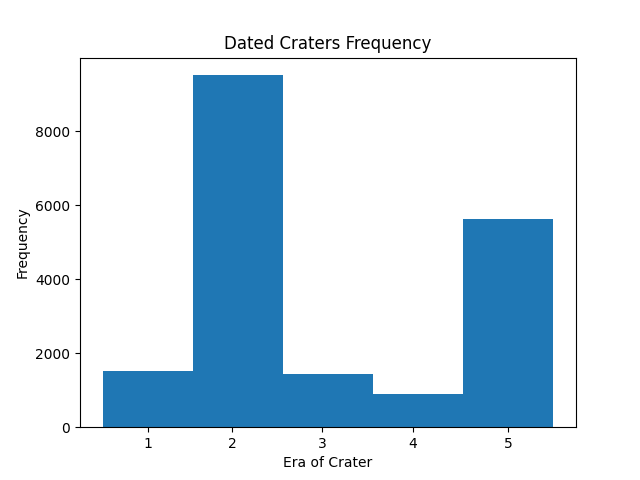

In [3]:
fig1 = plt.figure()
plt.hist(dated_craters["Age"], bins = 5)
plt.xticks([1.4, 2.15, 2.95, 3.75, 4.6], ["1", "2", "3", "4", "5"])
plt.title("Dated Craters Frequency")
plt.xlabel("Era of Crater")
plt.ylabel("Frequency")

Figure 1: A histogram demonstrating the number of craters that were dated to each of the age eras. Era 1 represents the craters in Yang et al. (2020) dated to the pre-Nectarian Age; Era 2 represents the craters dated to the Nectarian Age; Era 3 represents the craters dated to the Imbrian Age; Era 4 represents the craters dated to the Eratosthenian Age; Era 5 represents the craters dated to the Copernican Age.

From this histogram, we can see that there are significantly more craters of age "2" and of age "5". We need to keep this skew in mind, as our average rates may be biased toward the more immediate rates that occurred during these time periods.

Recall, age "2" symbolizes the Nectarian age, part of which was involved in the Late Heavy Bombardmen (LHB) period - therefore we may expect a higher overal rate as a result of this bias (Yang et al. (2020)). Furthermore, age "5" symbolizes the Copernican age, which runs from 1.1 Ga until today. Research suggests that the Copernican age has experienced a notable spike in cratering formation rate, such that the rate of crater formation has increased by a factor of 2.6 times within the last 290 Ma (0.29 Ga) (Mazrouei et al. (2019); Kirchoff et al. (2019); Ipatov et al.(2020); Morota et al. (2005)). Thus, it is also likely that we will see a rise in crater formation rates in comparison to the previous ages after the LHB. 

In order to begin this analysis, we must count the number of craters that are embedded in the dated craters. We will do this by cycling through both the dated craters in the Yang et al. (2020) dataset, as well as the `robbins_in_yang` data that was calculated to obtain the embedded craters. Notably, not all of the dated craters actually have embedded craters, therefore, if there was no crater detected within the dated crater, we input the 0 onto the data. This allows us to insert a column into the dataframe in order to conduct the appropriate calculations.

In [4]:
num_of_children_craters = {}
#lets start by using the older ages
for crater_id in dated_craters["ID"]:
  id = str(crater_id)
  for analyzed_id in craters_in_craters:
    if id == analyzed_id:
      num_of_craters = len(craters_in_craters[id])
      num_of_children_craters[id] = num_of_craters

total_embedded_craters = []
for crater_id in dated_craters["ID"]:
  id = str(crater_id)
  if id in num_of_children_craters:
    total_embedded_craters.append(num_of_children_craters[id])
  else:
    total_embedded_craters.append(0)

#Add Embedded Craters column to dated_craters DataFrame
dated_craters["Embedded Craters"] = total_embedded_craters

Now that we have the number of embedded craters matched to their respective craters, we can begin calculating the individual average rates by dividing the number of embedded craters by the estimated elapsed time since the formation of the crater.

Recall that the Yang et al. database divides the data into only five eras. The granularity of this data complicates the interpretation of the rate estimates we calculate. We are chosing to use the upper bound of the respective age to avoid the assumption that the craters in the Copernican age all happened last night (per se). We considered using the midpoint of the date range to counter the assumption that the craters from the pre-Nectarian age occurred all at the very creation of the moon (roughly 4.57 Ga by Snape et al. (2016)); however, we don't find any true advantage to using the midpoint versus the older age. This model should be taken no more than as an estimate of rate trends across both different ages, as well as different regions of the moon using currently accessible data.

We will now perform the individual average cratering rates. Recall that a rate of change is given by some "distance" traveled over some time. In this case we are calculating the number of craters (of diameter greater than 1km) formed on a particular part of the surface of the Moon over some amount of time. The number of craters formed in the area of a dated crater is the number of embedded craters plus itself. This number then gets divided by the upper bound of its age. We will do this for every crater in `dated_craters`.

In [5]:
older_ages = {"1": 4.57, "2": 3.92, "3": 3.85, "4": 3.20, "5": 1.10} #in Ga (billion years)

indv_cratering_rates_old = []
for index, crater_ids in enumerate(dated_craters["ID"]):
  crater_age = older_ages[str(dated_craters["Age"][index])]
  embedded_craters = dated_craters["Embedded Craters"][index] +1 #plus itself
  indv_cratering_rate = embedded_craters/crater_age
  indv_cratering_rates_old.append(indv_cratering_rate)

#Add Older Rates column to dated_craters DataFrame
dated_craters["Older Rates"] = indv_cratering_rates_old

### Parsing Crater Rates and Ages

Now that we have identified the rates attributed to each crater. We can parse the data into their resepective age categories to observe local trends in crater forming activity since the formation of the craters. We can do this by plotting the frequency of crater formation rates within an age group.

If the crater formation rate was constant, we would naturally expect the rate distributions to be very similar. We will need to parse the data into their respective age categories to make this analysis.

In [6]:
pre_nectarian_old_rates = [] # Age 1
nectarian_old_rates = [] # Age 2
imbrian_old_rates = [] # Age 3
eratosthenian_old_rates = [] # Age 4
copernican_old_rates = [] # Age 5

#Parse the rates based on their age 
for index, era in enumerate(dated_craters["Age"]):
  if era == 1:
    pre_nectarian_old_rates.append(dated_craters["Older Rates"][index])
  if era == 2:
    nectarian_old_rates.append(dated_craters["Older Rates"][index])
  if era == 3:
    imbrian_old_rates.append(dated_craters["Older Rates"][index])
  if era == 4:
    eratosthenian_old_rates.append(dated_craters["Older Rates"][index])
  if era == 5:
    copernican_old_rates.append(dated_craters["Older Rates"][index])

Now that the rates are parsed to their respective ages, we can plot the data onto histograms to allow us to see the crater formation rate frequency across different ages. The histograms themselves will be plotted under the "Results" section.

Notably, it will also be valuable to more concretely visualize the evolution of the rates across the five ages. Therefore, we will take the mean of the rates from each of the five ages and find the standard deviations. We will then plot this data onto an mean-error plot, which can be seen under the "Results" section. Below are the calculations.

In [7]:
#Find the mean of the rates
pre_nectarian_old_rates_mean = np.mean(pre_nectarian_old_rates)
nectarian_old_rates_mean = np.mean(nectarian_old_rates)
imbrian_old_rates_mean = np.mean(imbrian_old_rates)
eratosthenian_old_rates_mean = np.mean(eratosthenian_old_rates)
copernican_old_rates_mean = np.mean(copernican_old_rates)

#Find the standard deviation of rates
pre_nectarian_old_rates_std = np.std(pre_nectarian_old_rates)
nectarian_old_rates_std = np.std(nectarian_old_rates)
imbrian_old_rates_std = np.std(imbrian_old_rates)
eratosthenian_old_rates_std = np.std(eratosthenian_old_rates)
copernican_old_rates_std = np.std(copernican_old_rates)

### Crater Rate Interpretations

We must also keep in mind that this rate is an average rate of a crater with diameter >1m forming within a small area. As documented by Yang et al. (2020), the size of the craters go from as small as 8km in diameter to as large as over 500km in diameter. We can visualize this below.

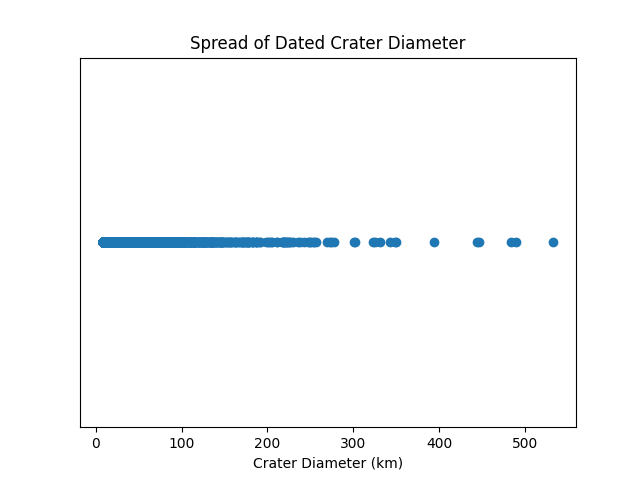

In [8]:
all_diameters = []
for diameter in dated_craters["Diam_km"]:
  all_diameters.append(diameter)

x = np.ones(len(all_diameters))
fig2 = plt.figure()
plt.yticks([])
plt.scatter(all_diameters,x)
plt.title("Spread of Dated Crater Diameter")
plt.xlabel("Crater Diameter (km)")
plt.show()

In [10]:
min_diam = min(all_diameters)
max_diam = max(all_diameters)
print("The minimum diameter of the dated craters is %.2f" % min_diam, "km, the maximum diameter of the dated craters is %.2f" % max_diam, ".")

The minimum diameter of the dated craters is 8.00 km, the maximum diameter of the dated craters is 532.88 .


Figure 2: A plot of all of the crater diameters in kilometers. This plot shows that there is a spread from 8km all the way up to 532.88km diametered craters.

We can see the distribution above. We can also see that there exist a dense section of diameters from 8km to roughly 250km. Due to this density, we are confident that taking the mean of the diameters is sufficient in allowing us to determine that the rate we calculated is the rate for any circular area of the moon of the mean diameter. This is because there does not seem to be a strong enough pull by the outliers to make too large of a difference in the mean for our limited purposes. We calculate the mean diameter below, and ultimately, the mean surface area that is accounted for in this rate.

In [11]:
mean_diameter = np.mean(all_diameters)
print("The mean diameter of the craters used is %.2f" % mean_diameter, "km")

mean_sa = np.pi*(mean_diameter/2)**2
print("The mean surface of the Moon accounted for is %.2f" % mean_sa ,"km^2")

The mean diameter of the craters used is 20.36 km
The mean surface of the Moon accounted for is 325.42 km^2


This is in reality only a small portion of the cratering rate, thus we must use an approximation of the surface area of the moon based on the previously used assumption that the moon is a perfect sphere with a radius of 1737.4 km.

In [12]:
MEAN_MOON_RADIUS = 1737.4
MOON_SURFACE_AREA = 4*np.pi*(MEAN_MOON_RADIUS**2)
moon_to_calculated_ratio = MOON_SURFACE_AREA / mean_sa

Calculating full Moon cratering rate approximations will require the `moon_to_calculated_ratio` term. We will reveal these cratering aproximations in the "Results" section.

### Cratering Rates by Coordinate Areas

We are also interested in seeing how different parts of the moon get impacted at different rates.

To start, we will want to divide the moon into 10° x 10° chunks. For example, we will want to find the cratering rates within latitudes 20 - 30 degrees and longitude 10 -20 degrees to get a sense for its local cratering activity. We will want to then store the mean rateof each square. This would result in Latitude x Longitude x Data matrix of size 18 x 36 x 1. Lets try to create this monstrocity.

In [13]:
#Function to get data for a square
def get_square_data(start_lat, end_lat, start_lon, end_lon, db):
  '''
  Find the mean rate (and standard deviation) of the dated craters within a
  a square-ish area defined by latitude and longitude corners.

  Args:
      start_lat: an int defining the lower bound of latitude
      end_lat: an int defining the upper bound of latitude
      start_lon: an int defining the lower bound of longitude
      end_lon: an int defining the upper bound of longitude
      db: the modified database of dated craters

  Return:
      a tuple containing the mean rate, and its standard deviation
  '''

  rates = []
  rate_used = "Older Rates"
  for index, ids in enumerate(db["ID"]):
    if start_lat <= db["Lat"][index] and end_lat > db["Lat"][index]:
      if start_lon <= db["Lon"][index] and end_lon > db["Lon"][index]:
        rate = db[rate_used][index]
        rates.append(rate)
  if len(rates) == 0:
    return 0
  rates_mean = np.mean(rates)
  return rates_mean

This function takes the latitude and longitude bounds that will be used to find the dated craters within a specific boundary. We then extract, scale, and store the rates of the dated craters identified within the bound. Once all of the dated craters are identified, the mean of the rates is taken. This mean rate is then returned to the user. This function will be critical to our matrix build below.

In [14]:
#Build the data matrix
lat_bounds = [-90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 
              50, 60, 70, 80, 90]
lon_bounds = [-180, -170, -160, -150, -140, -130, -120, -110, -100, -90, -80, 
              -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70,
              80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]

data_matrix = [] #will become a list of lists of tuples data_matrix[latitude][longitude][data (0 = mean)]
for i in range(len(lat_bounds)-1):
  lons = []
  for j in range(len(lon_bounds)-1):
    rate_data = get_square_data(lat_bounds[i], lat_bounds[i+1], lon_bounds[j], lon_bounds[j+1], dated_craters)
    lons.append(rate_data)
  data_matrix.append(lons)

#mirror the graph so Lat 90 is at the top
data_matrix_fixed = []
for index, rows in enumerate(data_matrix):
  data_matrix_fixed.append(data_matrix[len(data_matrix)-1-index])

#make data matrix into a numpy array to work with matplotlib functions
data_array = np.array(data_matrix_fixed)


Now that we have our data matrix properly formatted, we can now plot it onto a heat map where we can see the average cratering rate across different parts of the moon! 

(Note that we have left available both the list of lists version, as well as the numpy array version of this data.)

## Results
This section will detail the majority of the plots generated through the analysis

### Crater Rates With Respect to their Age

Text(0.5, 0.98, 'Cratering Rates Across Eras')

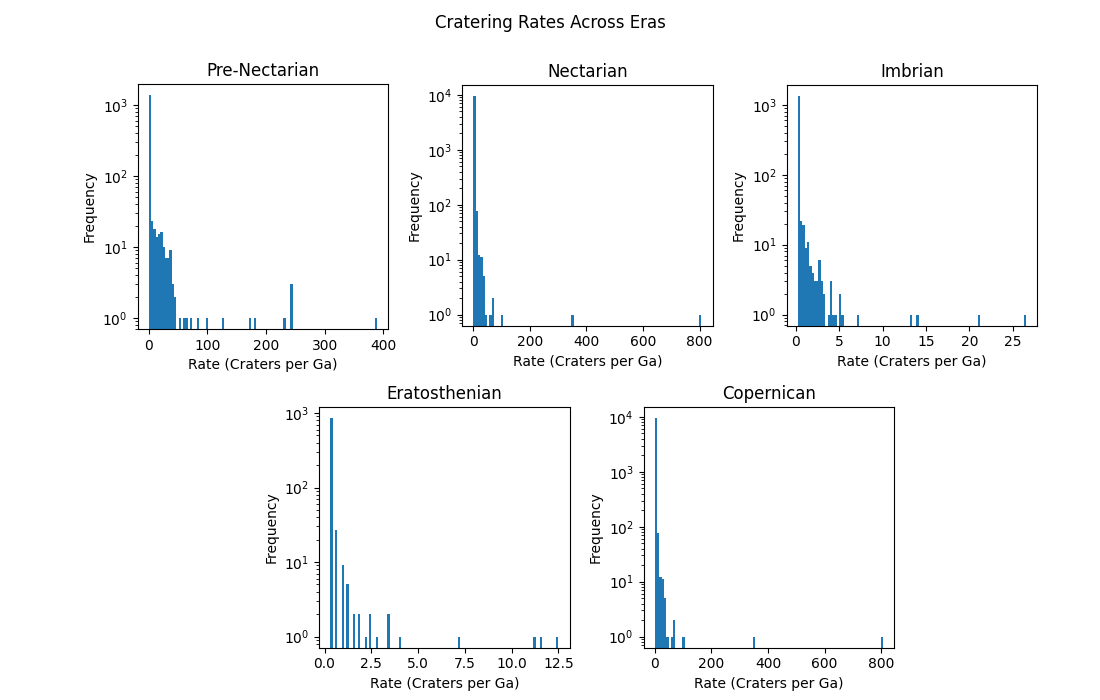

In [79]:
fig3, axes = plt.subplots(2,3, figsize=(11,7))
axes[1][2].set_visible(False)
axes[1][0].set_position([0.29,0.075,0.228,0.343])
axes[1][1].set_position([0.585,0.075,0.228,0.343])

axes[0][1].set_position([0.42,0.535,0.228,0.343])
axes[0][2].set_position([0.715,0.535,0.228,0.343])

axes[0][0].hist(pre_nectarian_old_rates, bins = 100)
axes[0][0].set_yscale("log")
axes[0][0].set_xlabel("Rate (Craters per Ga)")
axes[0][0].set_ylabel("Frequency")
axes[0][0].set_title("Pre-Nectarian")

axes[0][1].hist(nectarian_old_rates, bins = 100)
axes[0][1].set_yscale("log")
axes[0][1].set_xlabel("Rate (Craters per Ga)")
axes[0][1].set_ylabel("Frequency")
axes[0][1].set_title("Nectarian")

axes[0][2].hist(imbrian_old_rates, bins = 100)
axes[0][2].set_yscale("log")
axes[0][2].set_xlabel("Rate (Craters per Ga)")
axes[0][2].set_ylabel("Frequency")
axes[0][2].set_title("Imbrian")

axes[1][0].hist(eratosthenian_old_rates, bins = 100)
axes[1][0].set_yscale("log")
axes[1][0].set_xlabel("Rate (Craters per Ga)")
axes[1][0].set_ylabel("Frequency")
axes[1][0].set_title("Eratosthenian")

axes[1][1].hist(nectarian_old_rates, bins = 100)
axes[1][1].set_yscale("log")
axes[1][1].set_xlabel("Rate (Craters per Ga)")
axes[1][1].set_ylabel("Frequency")
axes[1][1].set_title("Copernican")

fig3.suptitle("Cratering Rates Across Eras")

As evident by the results above the histograms do not seem to follow similar trends. In fact, we see that there are remnants of highly bombarded craters from the pre-Nectarian and Nectarian ages, as predicted by the LHB.

To get a better image of this evolution of the cratering rate over time, lets plot a mean-errorbar graph that will make this more apparant.

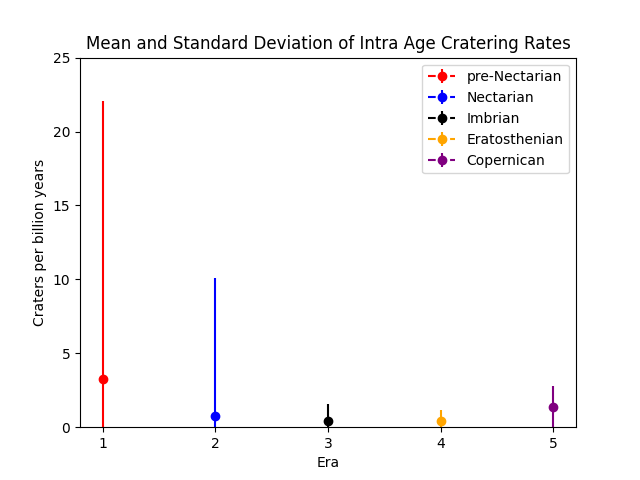

In [80]:
#plot errorbars intra-age
fig4 = plt.figure()
plt.errorbar(1, pre_nectarian_old_rates_mean, yerr= pre_nectarian_old_rates_std, fmt='--o', color='red')
plt.errorbar(2, nectarian_old_rates_mean, yerr= nectarian_old_rates_std, fmt='--o', color='blue')
plt.errorbar(3, imbrian_old_rates_mean, yerr= imbrian_old_rates_std, fmt='--o', color='black')
plt.errorbar(4, eratosthenian_old_rates_mean, yerr= eratosthenian_old_rates_std ,fmt='--o',color='orange')
plt.errorbar(5, copernican_old_rates_mean, yerr= copernican_old_rates_std, fmt='--o', color='purple')
plt.title("Mean and Standard Deviation of Intra Age Cratering Rates")
plt.xlabel("Era")
plt.xticks([1,2,3,4,5])
plt.ylabel("Craters per billion years")
plt.legend(["pre-Nectarian", "Nectarian", "Imbrian", "Eratosthenian", "Copernican"], loc = "upper right")
plt.ylim((0,25))
plt.show()

In [81]:
print("The mean flux of crater formation of craters of diameter >1km in the copernican")
print("age is of %.2f" % copernican_old_rates_mean,"For some surface area.")

The mean flux of crater formation of craters of diameter >1km in the copernican
age is of 1.39 For some surface area.


We can see that from the pre-Nectarian age (1) to the Eratosthenian age (4) the moon experienced a general decrease in crater formation flux, where craters were still forming, just at a lower rate. One would normally expect this considering the Late Heavy Bombardment lasted only up to roughly the midpoint of the Nectarian age (~3.9Ga). Interestingly, we find that there is an increase in the cratering rate in the Copernican age with respect to the Eratosthenian age, in accordance to other observations made. We can calculate the ratio of the Copernican and Ertosthenian flux to see if our approximation gets close to the Mazrouei et al. (2019)'s approximation of a flux increase of 2.6 times.

In [82]:
flux_increase = copernican_old_rates_mean / eratosthenian_old_rates_mean
print("We find that crater formation of diameter > 1km has increased by a fator of %.2f" % flux_increase)
print("within the last 1.1 Ga (billion years)")

We find that crater formation of diameter > 1km has increased by a fator of 3.42
within the last 1.1 Ga (billion years)


Although this factor is greater than that of Mazrouei et al. (2019)'s  estimate, it must be remembered that the data used in this analysis is very granular. We may also attribute this to our limitation is resources, since we are unable to make our own observations / age calculations on the lunar craters. Even so, we are able to witness an apparent increase in flux within the last billion years. This observation would be helpful in advocating for an increase in research of Near-Earth Objects.

### Cratering Rate Approximation
Recall that the cratering rates so far have dealt with a localized area. On average, we determined that our rates were accounting for only 325.42 km^2 of the surface. Therefore, by mutiplying our rates by the ratio of the total surface area over theb surface area previously accounted for, we get the following result for the Moon using the Copernican Age Rate.

In [83]:
moon_copernican_rate = moon_to_calculated_ratio * copernican_old_rates_mean
print("Craters form on the Moon on an average of %.2f" % moon_copernican_rate, "times per billion years.")
print("Or otherwise")
moon_copernican_rate_ma = moon_copernican_rate / 1000
print("Craters form on the Moon on an average of %.2f" % moon_copernican_rate_ma, "times per million years")

Craters form on the Moon on an average of 161840.39 times per billion years.
Or otherwise
Craters form on the Moon on an average of 161.84 times per million years


To approximate an average cratering age across the entire lifetime of the moon, we would need to consider all of the rates, which would produce the following collective rate.

In [84]:
all_rates = pre_nectarian_old_rates + nectarian_old_rates + imbrian_old_rates + eratosthenian_old_rates + copernican_old_rates
all_time_mean_rate = np.mean(all_rates)
moon_all_time_rate = moon_to_calculated_ratio * all_time_mean_rate
print("Craters form on the Moon on an average of %.2f" % moon_all_time_rate, "times per billion years.")
print("Or otherwise")
moon_all_time_rate_ma = moon_all_time_rate / 1000
print("Craters form on the Moon on an average of %.2f" % moon_all_time_rate_ma, "times per million years")

Craters form on the Moon on an average of 129446.61 times per billion years.
Or otherwise
Craters form on the Moon on an average of 129.45 times per million years


We found a couple rate estimates! However, this is suggesting that the entire moon gets bombarded at an equal rate. Morota et al. (2005) suggests that the moon experiences an asymmetrical cratering rate influenced by the orbital synchronization of the Moon with the Earth. Therefore, we will also analyze the cratering rates with respect to latitude and longitude. This will give us a better idea of how the cratering rates are distributed cross the surface of the moon.

### Cratering Rates by Coordinate Areas

Lets observe how the cratering rates are distributed across the recorded surface of the Moon!

In [85]:
def project_2d_to_sphere(ax, values, cmap=None):
    """
    Project a 2D heatmap onto a sphere.

    Args:
        ax: A matplotlib axis to plot on
        values: A numpy meshgrid type object containing the data to plot
    """
    # Doing
    #    lon=linspace(0, 360, x) 
    #    lat=linspace(-90, 90, y) 
    #    Lon, Lat = meshgrid(lon, lat) 
    # gives array of size y by x.
    lon = np.linspace(0, 2*np.pi, values.shape[1])
    lat = np.linspace(0, np.pi, values.shape[0])
    X = 10 * np.outer(np.sin(lat), np.cos(lon))
    Y = 10 * np.outer(np.sin(lat), np.sin(lon))
    Z = 10 * np.outer(np.cos(lat), np.ones(np.size(lon)))

    if cmap == None:
        cmap = plt.get_cmap()
    
    normalized_values = ((values - np.min(values))
                         / (np.max(values) - np.min(values)))
    colors = cmap(normalized_values)

    ax.plot_surface(X, Y, Z, facecolors=colors)

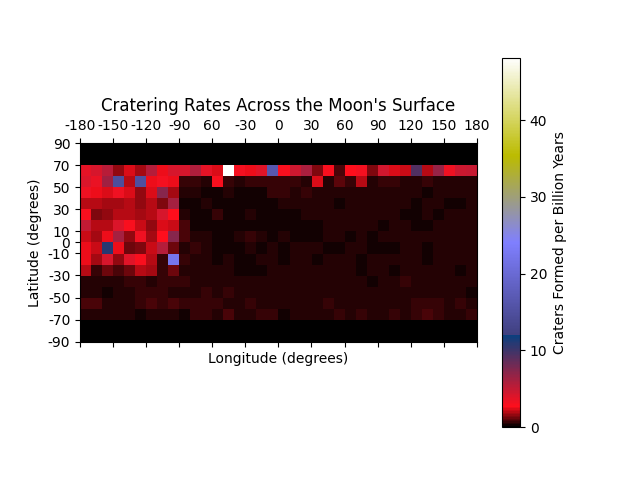

In [24]:
fig5 = plt.figure()
ax = fig.add_subplot()

hist2d = ax.matshow(data_array, cmap='gist_stern')
fig.colorbar(hist2d, ax=ax).set_label("Craters Formed per Billion Years", rotation = 90)
plt.title("Cratering Rates Across the Moon's Surface")
plt.xlabel("Longitude (degrees)")
plt.ylabel("Latitude (degrees)")
plt.xticks([-0.5, 2.5, 5.5, 8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5, 29.5, 32.5, 35.5],
           labels= ["-180", "-150", "-120", "-90", "60", "-30", "0", "30", "60", "90", "120", "150", "180"])
plt.yticks([-0.5, 1.5, 3.5, 5.5, 7.5, 8.5, 9.5, 11.5, 13.5, 15.5 ,17.5], 
           labels = ["90", "70", "50", "30", "10", "0", "-10", "-30", "-50", "-70", "-90"])
plt.show()

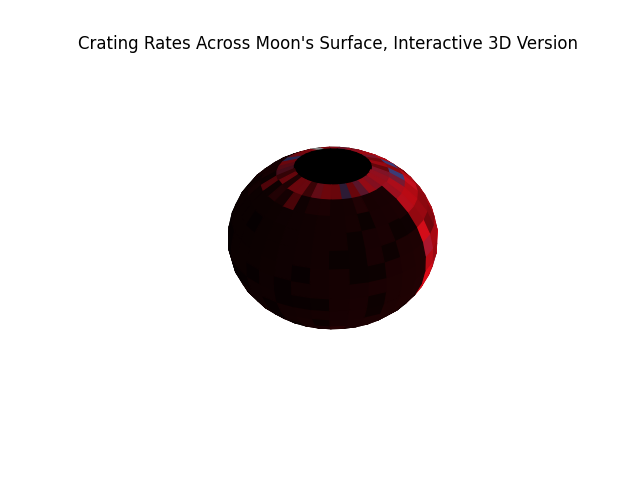

In [25]:
# A 3D version of the same plot
fig6 = plt.figure()
ax = fig.add_subplot(projection="3d")
project_2d_to_sphere(ax, data_array, cmap=cm.gist_stern)
plt.grid(False)
plt.axis("off")
plt.title("Crating Rates Across Moon's Surface, Interactive 3D Version")
plt.show()

Fascinating! First notable thing is that it would seem as through there is a congregaton of embeddedd craters within longitudes -180° to -90° and within latitudes -30° to 70°. Looking this area up on the LROC shows that this is the Highlands! Furthermore, the darker red sections when looked up on LROC give spots of lunar mare! 

Unfortunately, due to the limited data base, we do not have information for the Latitudes 70° to 90° and -70° to -90°. However, it is still amazing to see such an intense result with the limited data available.